在之前的代码中，我们可以查看这个训练log。在这时，我发现某一轮的数据发生了异常，dice急降为0，虽然我设置了checkpoint callback，可以将val_dice最好的模型保存下来，但是还是需要探究一下这个模型出了什么问题。

In [1]:
%load_ext autoreload
%autoreload 2

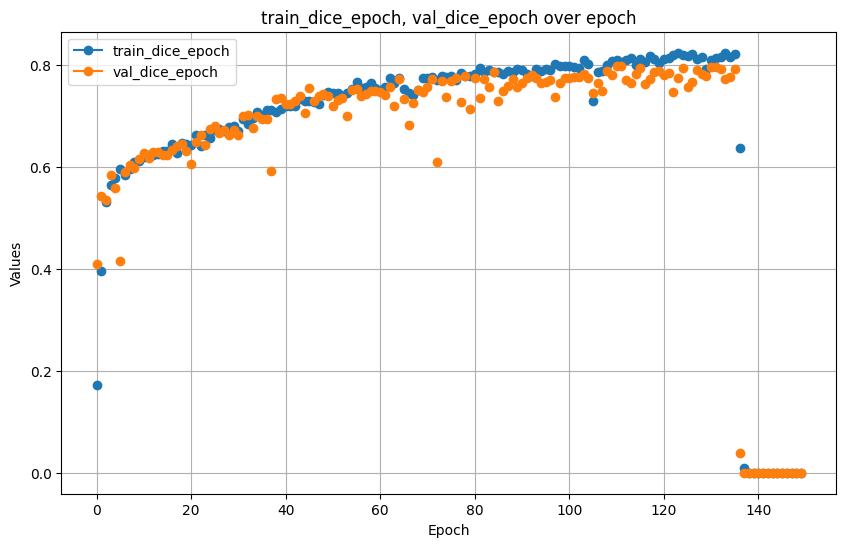

In [2]:
from UNethology.plot_tools import plot_metrics
plot_metrics('UNet_logs/UNet/version_33/metrics.csv', 'epoch', ['train_dice_epoch', 'val_dice_epoch'])

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from monai.networks.nets import BasicUNet
import pytorch_lightning as pl

# 创建一个字典来保存中间层的特征图
feature_maps = {}

def hook_fn(module, input, output):
    # 将特征图保存在字典中
    feature_maps[module] = output


# 创建一个与训练时定义相同的模型类
class BasicUNetLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = BasicUNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            features=(32,32,64,128,256,32),
            dropout=0.50,
        )
    
    def forward(self, x):
        return self.model(x)

# 使用 load_from_checkpoint 加载检查点
checkpoint_path = "UNet_logs/UNet/version_33/last.ckpt"
model = BasicUNetLightning.load_from_checkpoint(checkpoint_path)
model.model.conv_0.register_forward_hook(hook_fn)
model.model.upcat_4.register_forward_hook(hook_fn)
model.model.final_conv.register_forward_hook(hook_fn)

BasicUNet features: (32, 32, 64, 128, 256, 32).


Mask Tensor Shape: torch.Size([1, 256, 256])


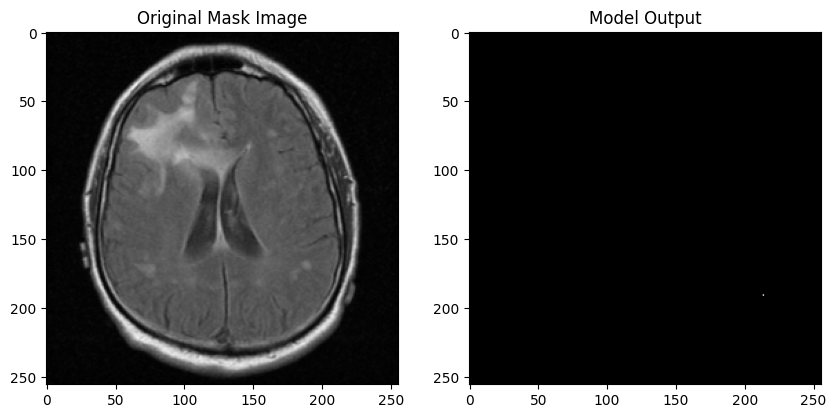

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

# 图像文件路径
image_path = 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif'

# 加载图像
image = Image.open(image_path)
#  转换为 PyTorch Tensor
transform = transforms.ToTensor()
image_tensor = transform(image)

# 检查 Tensor 的大小
print("Mask Tensor Shape:", image_tensor.shape)
# 将 mask_tensor 添加批次维度并输入到模型中
image_input = image_tensor.unsqueeze(0)  # 添加批次维度，形状为 (1, 1, H, W)

model.eval() # 只有eval模式才能保证模型在推理时的输出一致
with torch.no_grad(): # 不信你可以注释掉这两行，你会发现每次进行输出，都会有些许不同
    output = torch.sigmoid(model(image_input)) 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("Original Mask Image")

# 显示模型输出
plt.subplot(1,2,2)
output_image = output.squeeze().detach().numpy()  # 去除批次和通道维度
plt.imshow(output_image, cmap='gray')
plt.title("Model Output")
plt.show()

Feature Map Shape: torch.Size([1, 1, 256, 256])


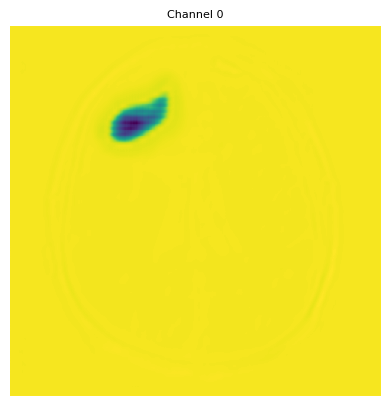

In [5]:
# 获取特定层的特征图
chosen_layer = list(feature_maps.keys())[2] # 可选的数字有0/1/2
feature_map = feature_maps[chosen_layer]
print("Feature Map Shape:", feature_map.shape)

from UNethology.plot_tools import visualize_feature_map

visualize_feature_map(feature_map)

可以看到模型几乎已经丧失了所有的学习能力和手段。只有在最后一层输出的特征图中，我们能看到他还保留一点残存的前世记忆。

我们可视化出它模型的权重，并且与正常模型进行对比

BasicUNet features: (32, 32, 64, 128, 256, 32).


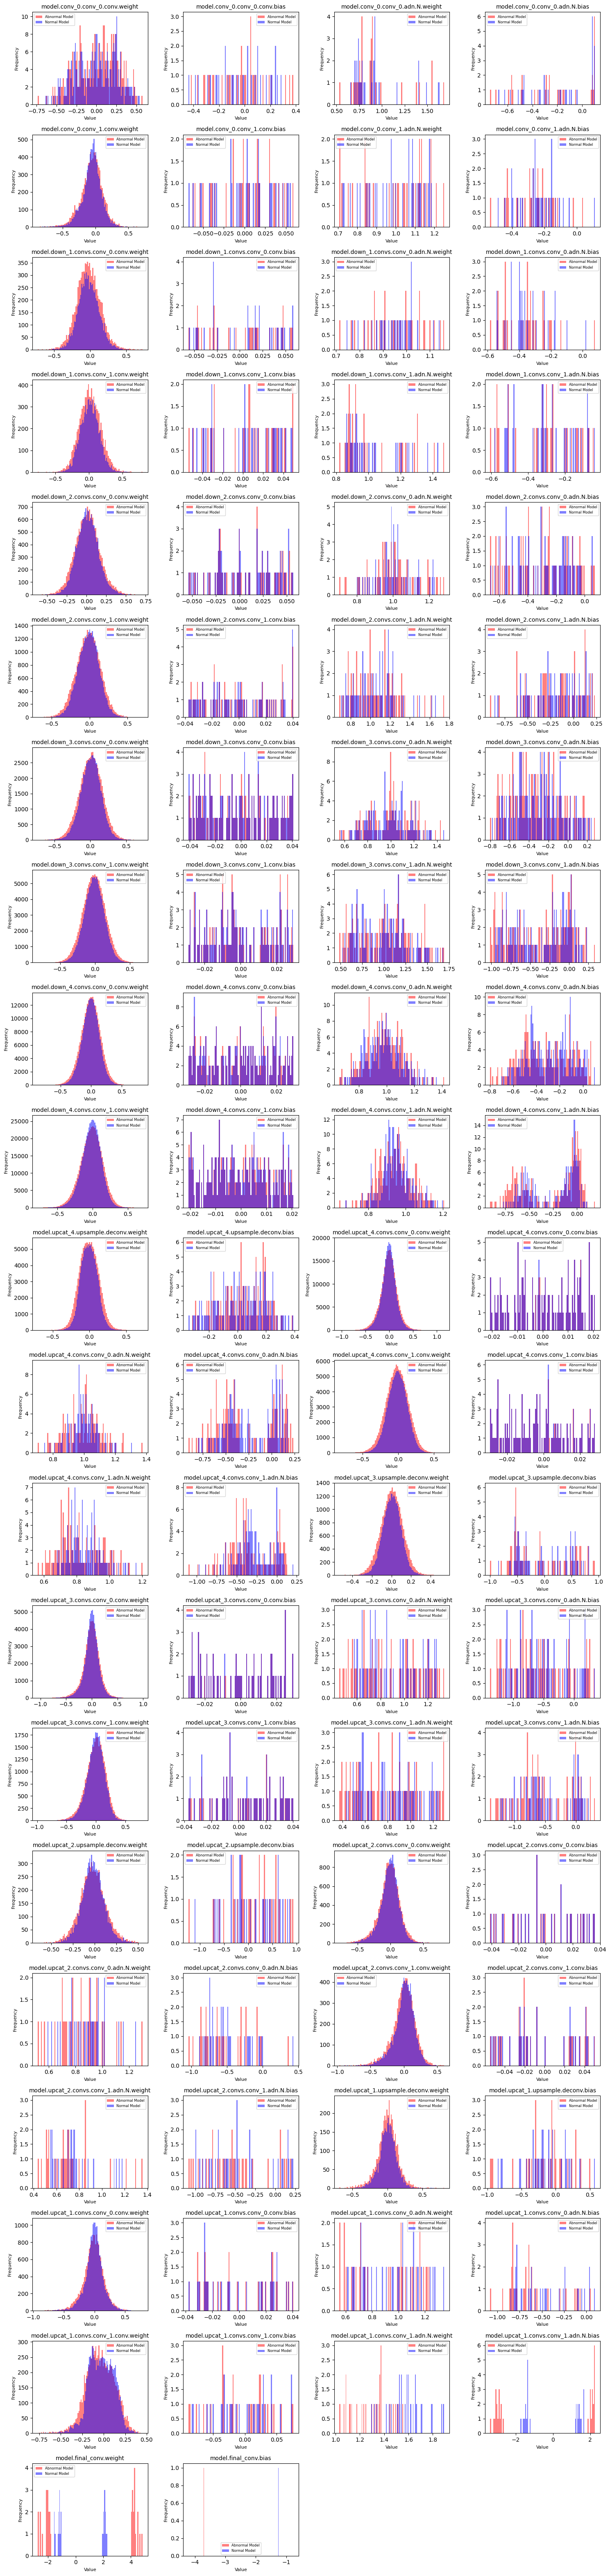

In [ ]:
import matplotlib.pyplot as plt
import math

# 加载正常模型
normal_model = BasicUNetLightning.load_from_checkpoint('UNet_logs/UNet/version_33/UNet-epoch=111-val_dice=0.7980.ckpt')

# 设置网格大小
num_params = sum(1 for param in model.parameters() if param.requires_grad)
cols = 4  # 每行的列数
rows = math.ceil(num_params / cols)  # 根据参数数量计算行数

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # 生成网格

# 展示每层的权重分布
for i, (name, param) in enumerate(model.named_parameters()):
    if param.requires_grad:
        # 获取相同层的正常模型的参数
        normal_param = dict(normal_model.named_parameters())[name]

        ax = axes[i // cols, i % cols]
        
        # 绘制异常模型的权重分布
        ax.hist(param.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, color='red', label='Abnormal Model')
        
        # 绘制正常模型的权重分布
        ax.hist(normal_param.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, color='blue', label='Normal Model')
        
        ax.set_title(f"{name}", fontsize=10)
        ax.set_xlabel("Value", fontsize=8)
        ax.set_ylabel("Frequency", fontsize=8)
        ax.legend(fontsize=6)

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


在最后几幅图中，我看到最后一层上采样（upcat_1）和final_conv的weight and bias，两个模型似乎不尽相同。我们来验证一下，通过比较它们的特征图。

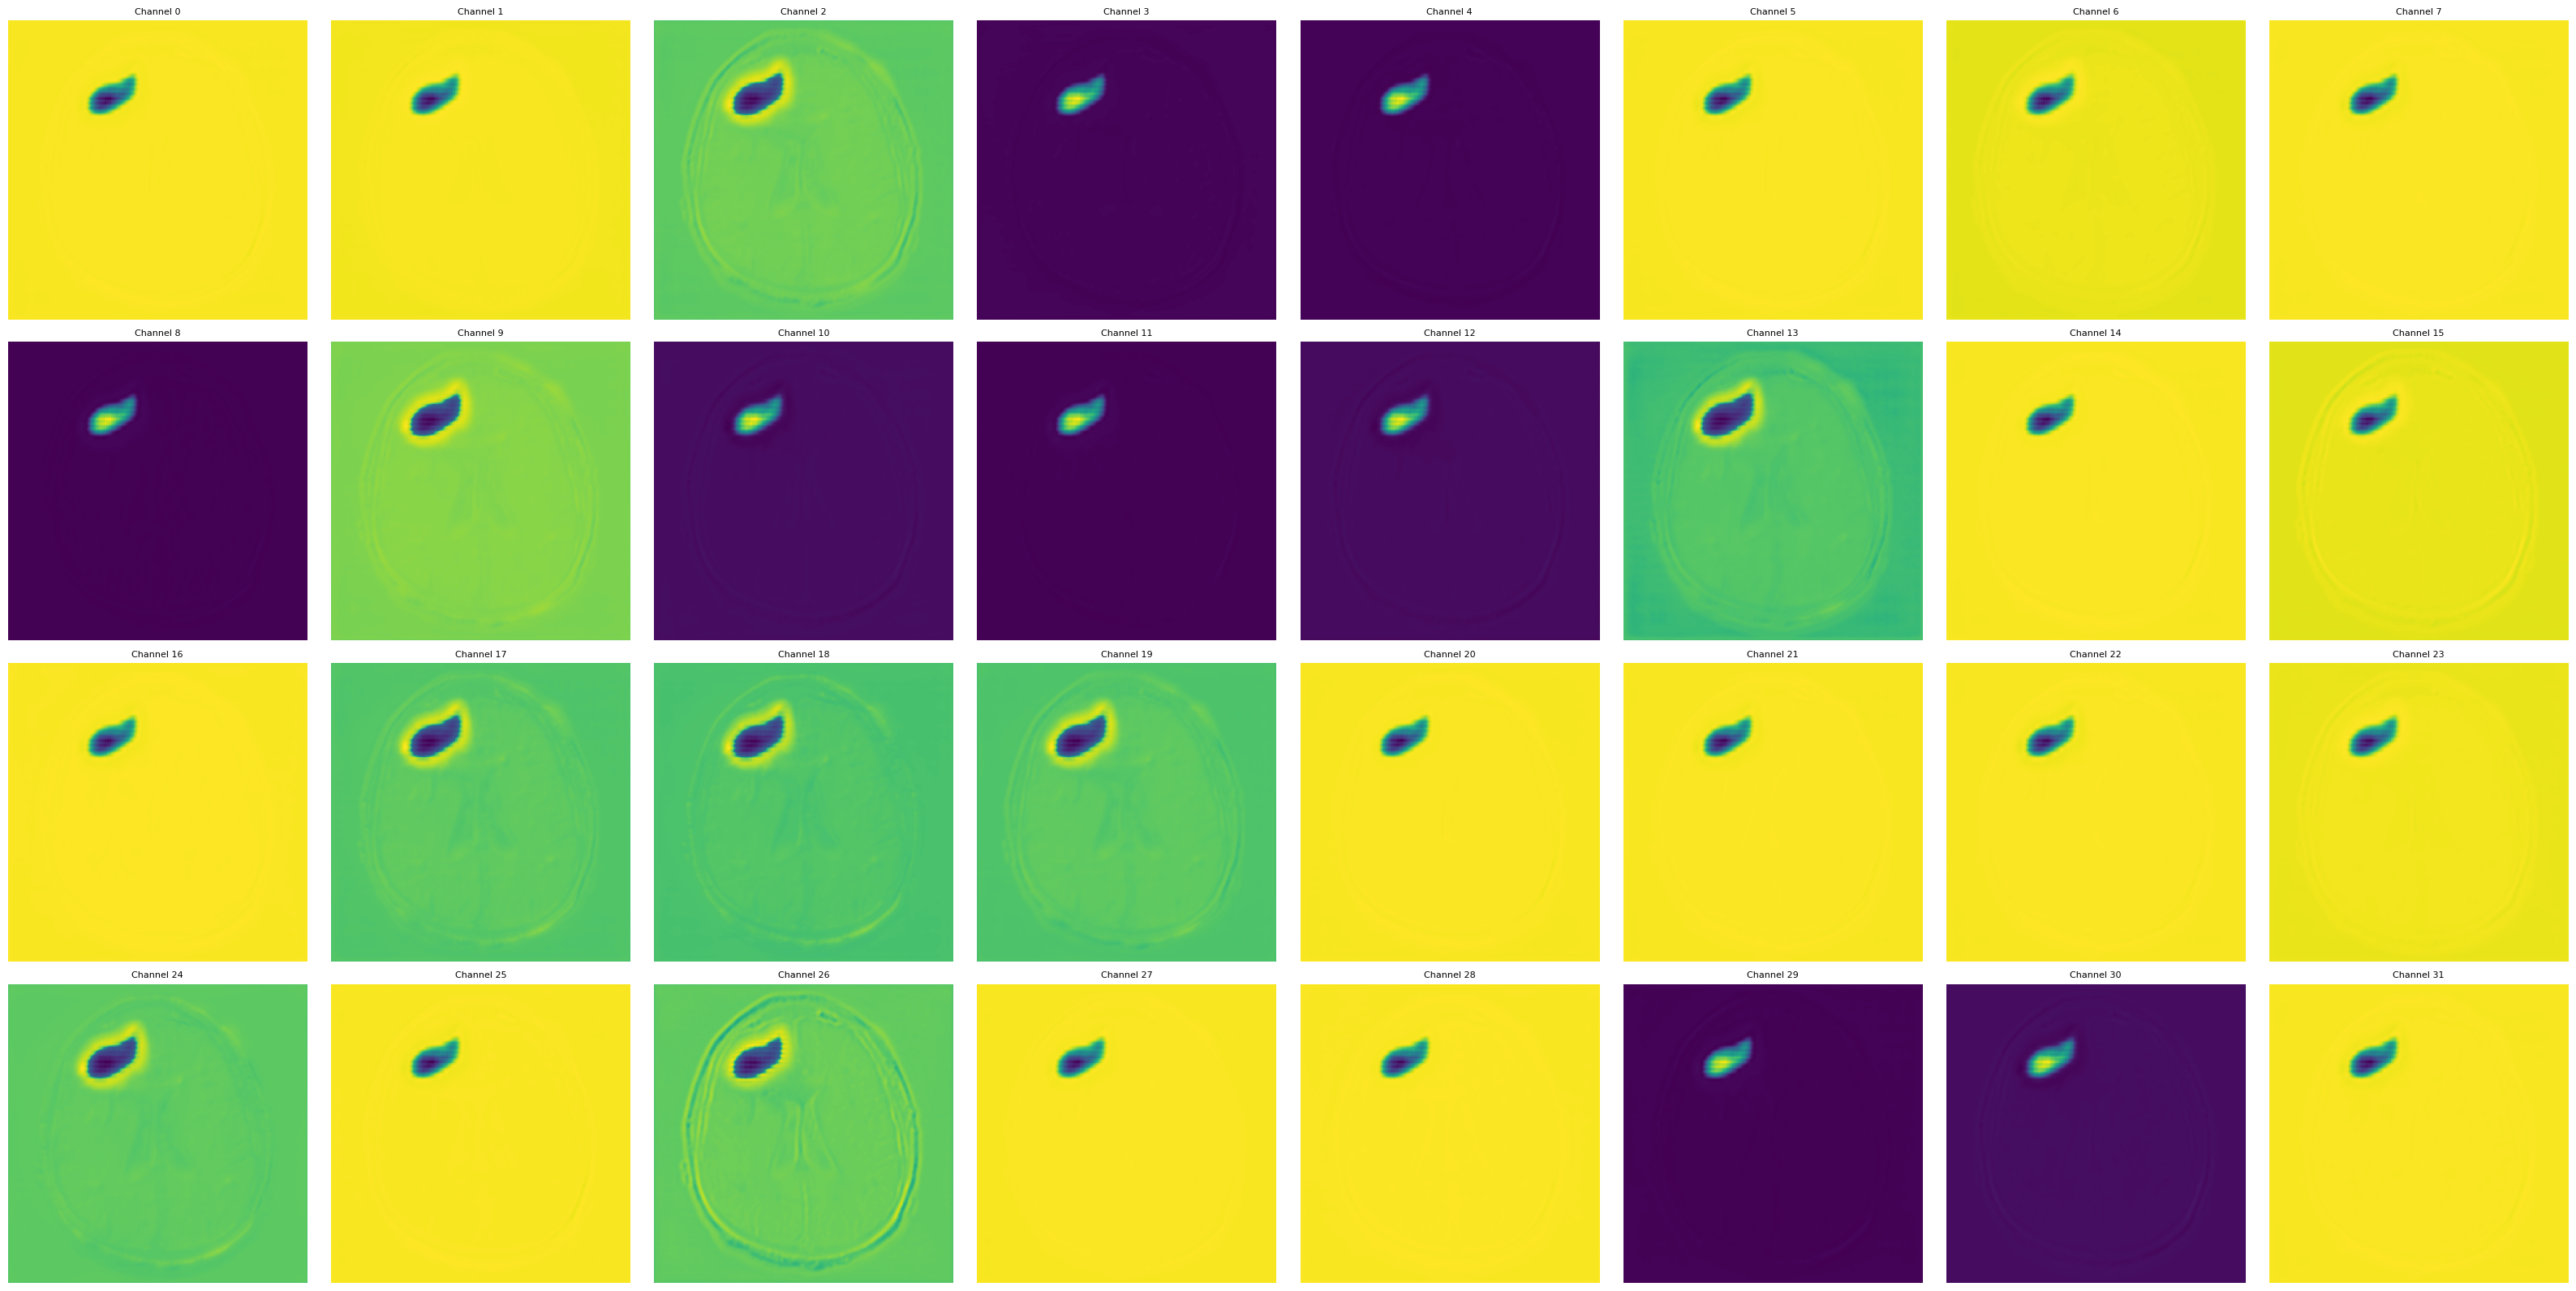

In [29]:
feature_maps = {}
index_of_layer = 4 # 修改这里改获取不同的钩子的特征图

model.model.conv_0.register_forward_hook(hook_fn)
model.model.upcat_4.register_forward_hook(hook_fn)
model.model.upcat_3.register_forward_hook(hook_fn)
model.model.upcat_2.register_forward_hook(hook_fn)
model.model.upcat_1.register_forward_hook(hook_fn)
model.model.final_conv.register_forward_hook(hook_fn)
model.eval()
with torch.no_grad():
    output = torch.sigmoid(model(image_input)) 

visualize_feature_map(feature_maps[list(feature_maps.keys())[index_of_layer]])

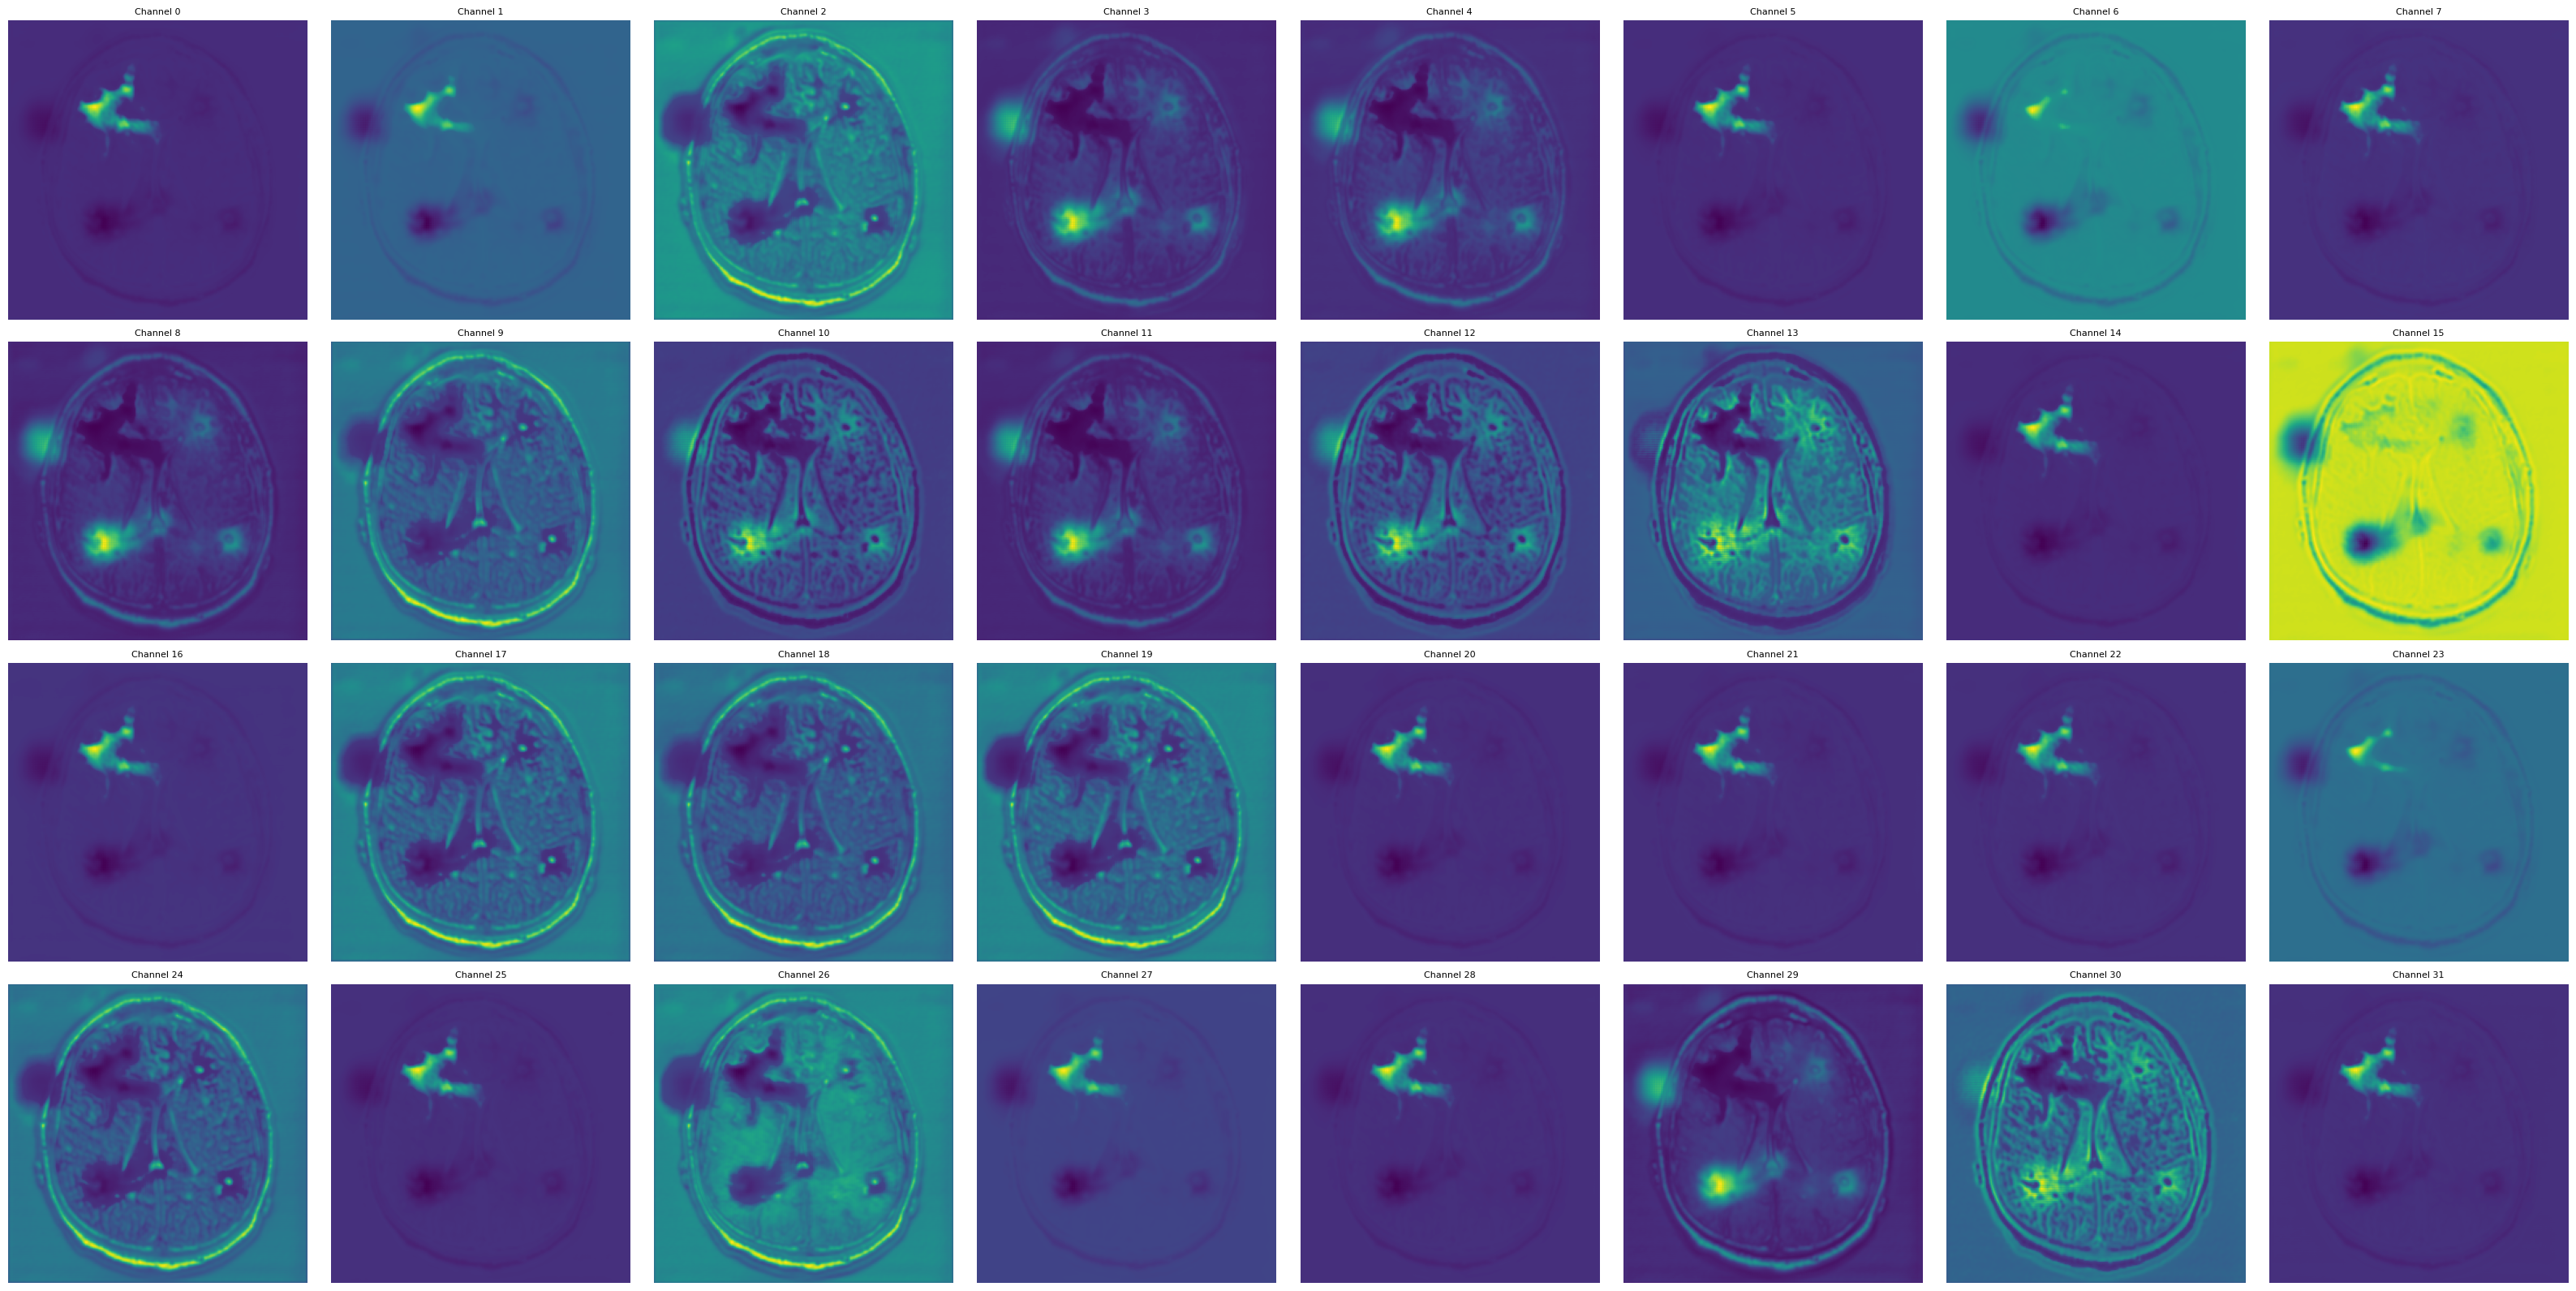

In [30]:
feature_maps = {}

normal_model.model.conv_0.register_forward_hook(hook_fn)
normal_model.model.upcat_4.register_forward_hook(hook_fn)
normal_model.model.upcat_3.register_forward_hook(hook_fn)
normal_model.model.upcat_2.register_forward_hook(hook_fn)
normal_model.model.upcat_1.register_forward_hook(hook_fn)
normal_model.model.final_conv.register_forward_hook(hook_fn)

normal_model.eval()
with torch.no_grad(): # 不信你可以注释掉这两行，你会发现每次进行输出，都会有些许不同
    normal_output = torch.sigmoid(normal_model(image_input))

visualize_feature_map(feature_maps[list(feature_maps.keys())[index_of_layer]])



我们对比不同的特征图发现，几乎从上采样开始，异常模型的特征图就几乎不可使用了，正常状态下，一般都是在lesion区域出现黄色（即值得预测的区域）

---

总之我们可以确认异常模型的哪些部分出现了问题，我猜测是权重初始化的问题，下次见再说吧。